In [2]:
from autograd import numpy as np
from cosmoTransitions import generic_potential
from cosmoTransitions import helper_functions 
from cosmoTransitions import pathDeformation as pd 
from cosmoTransitions import finiteT as ft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy.optimize import minimize
from scipy import linalg
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.animation import PillowWriter
from IPython.display import Image
import pickle

sqrt = np.sqrt
log = np.log
pi = np.pi
sin = np.sin
cos = np.cos

# TRSM model parameters

vh, vs, vx = 246.22, 140., 100.
vh2, vs2, vx2 = vh**2, vs**2, vx**2

mh2 = 125**2

gL, gY, yt = 0.6528, 0.35, 0.9937
gL2, gY2, yt2 = gL**2, gY**2, yt**2

M12, M22, M32 = mh2, 300**2, 450**2

M = np.array([M12,M22,M32])

θhs, θhx, θsx = -0.129, 0.226, -0.899


In [3]:
# Compute quartic couplings from masses, mixing angles, and vevs

def couplings(M):

    c1, c2, c3, s1, s2, s3 = cos(θhs), cos(θhx), cos(θsx), sin(θhs), sin(θhx), sin(θsx) 

    R = np.array([[c1*c2, -s1*c2, -s2], 
                  [s1*c3 - c1*s2*s3, c1*c3 + s1*s2*s3, -c2*s3], 
                  [c1*s2*c3 + s1*s3, c1*s3 - s1*s2*c3, c2*c3]])
    
    λφ = λS = λX = λφs = λφx = λsx = 0

    for i in range(len(M)):
        λφ += (0.5/vh2)*M[i]*(R[i][0]**2)
        λS += (0.5/vs2)*M[i]*(R[i][1]**2)
        λX += (0.5/vx2)*M[i]*(R[i][2]**2)
        λφs += (1/(vh*vs))*M[i]*R[i][0]*R[i][1]
        λφx += (1/(vh*vx))*M[i]*R[i][0]*R[i][2]
        λsx += (1/(vs*vx))*M[i]*R[i][1]*R[i][2]


    return λφ, λS, λX, λφs, λφx, λsx


# Check if these couplings satisfy boundedness from below condition (the printed quantities below have to be positive) 
λφ, λS, λX, λφs, λφx, λsx = couplings(M)
  
print(λφ,λS,λX)
print("\n")

λφs_bar, λφx_bar, λsx_bar = λφs + 2*sqrt(λφ*λS), λφx + 2*sqrt(λφ*λX), λsx + 2*sqrt(λS*λX)
print(λφs_bar, λφx_bar, λsx_bar)
print("\n")

print(sqrt(λS)*λφx + sqrt(λX)*λφs + sqrt(λφ)*λsx + sqrt(λφ*λS*λX) + sqrt(λφs_bar*λφx_bar*λsx_bar))

0.22230777818717729 3.9161683542119547 6.3828349399063


1.0132376856822523 3.6989465142254216 6.452593126123191


6.053397700752759


In [4]:
# Compute scalar masses from mass matrix diagonalization

def scalar_masses(mhh2,mss2,mxx2,mhs2,mhx2,msx2):
    
    # Stack into a (N, 3, 3) array (one 3x3 matrix per temperature)
    Msq = np.stack([
        np.stack([mhh2, mhs2, mhx2], axis=-1),
        np.stack([mhs2, mss2, msx2], axis=-1),
        np.stack([mhx2, msx2, mxx2], axis=-1)
        ], axis=-1)
    
    # Compute eigenvalues for each 3x3 matrix (shape: (N, 3))
    msq = np.linalg.eigvalsh(Msq)  # Eigenvalues are sorted
    ms2, mh2, mx2 = msq[..., 0], msq[..., 1], msq[..., 2]
    
    return ms2, mh2, mx2 

In [5]:
# TRSM model class

λφ, λS, λX, λφs, λφx, λsx = couplings(M)   
    
# Compute mass parameters from couplings and vevs
μφ2 = -(λφ*vh2 + 0.5*λφs*vs2 + 0.5*λφx*vx2)
μS2 = -(λS*vs2 + 0.5*λφs*vh2 + 0.5*λsx*vx2)
μX2 = -(λX*vx2 + 0.5*λφx*vh2 + 0.5*λsx*vs2)

class TRSM(generic_potential.generic_potential):

    def init(self,M):

        self.Ndim = 3

        self.renormScaleSq = vx2 
        
        self.Tmax = 1000
        
    
    def forbidPhaseCrit(self, X): # Forbid degenerate field values (Z2 symmetry)
       
        H, S, A = X[...,0], X[...,1], X[...,2]
        
        return (H < -5.0).any() or (S < -5.0).any() or (A < -5.0).any()

    
    def V0(self, X): # Tree-level potential
        
        X = np.asanyarray(X)
        
        H, S, A = X[...,0], X[...,1], X[...,2]
        
        H2, S2, A2 = H**2, S**2, A**2
        H4, S4, A4 = H2**2, S2**2, A2**2
        
        
        r = (1/2)*(μφ2*H2 + μS2*S2 + μX2*A2) + (1/4)*(λφ*H4 + λS*S4 + λX*A4 + λφs*H2*S2 + λφx*H2*A2 + λsx*S2*A2)
        
        return r

        
    def boson_massSq(self, X, T): # Compute masses and dof for bosons 
        
        H, S, A = X[...,0], X[...,1], X[...,2]
        
        H2, S2, A2, HS, HA, SA, T2 = H**2, S**2, A**2, H*S, H*A, S*A, T**2
        
        Πh = (3/16)*gL2 + (1/16)*gY2 + (1/4)*λφ + (1/24)*(λφs + λφx) + (1/4)*yt2
        Πs = (1/4)*λS + (1/24)*(λφs + λsx)
        Πx = (1/4)*λX + (1/24)*(λφx + λsx)

        mhh2 = μφ2 + 3*λφ*H2 + 0.5*λφs*S2 + 0.5*λφx*A2 + Πh*T2
        mss2 = μS2 + 0.5*λφs*H2 + 3*λS*S2 + 0.5*λsx*A2 + Πs*T2
        maa2 = μX2 + 0.5*λφx*H2 + 0.5*λsx*S2 + 3*λX*A2 + Πx*T2
        mhs2 = λφs*HS
        mha2 = λφx*HA
        msa2 = λsx*SA
        
        MH2, MS2, MX2 = scalar_masses(mhh2,mss2,maa2,mhs2,mha2,msa2)
        
        mWt2 = 0.25*gL2*H2 
        mWl2 = mWt2 + (11/6)*gL2*T2
        mZt2 = 0.25*(gL2 + gY2)*H2 
        mZl2 = 0.5*mZt2 + (11/12)*(gL2 + gY2)*T2 + sqrt((0.125*(gL2 + gY2)*H2 + (11/12)*(gL2 + gY2)*T2)**2 - (11/12)*(gL2)*(gY2)*(T2)*(H2 + (11/3)*T2))
        mγl2 = 0.5*mZt2 + (11/12)*(gL2 + gY2)*T2 - sqrt((0.125*(gL2 + gY2)*H2 + (11/12)*(gL2 + gY2)*T2)**2 - (11/12)*(gL2)*(gY2)*(T2)*(H2 + (11/3)*T2))
        
        Mb = np.stack([MH2, MS2, MX2, mWt2, mWl2, mZt2, mZl2, mγl2], axis=-1)

        dof = np.array([1, 1, 1, 4, 2, 2, 1, 1])

        c = np.array([1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5])

        return Mb, dof, c

    
    def fermion_massSq(self, X): # Compute masses and dof for fermions
        
        H = X[...,0]
        H2 = H**2
        
        mt2 = 0.5*(yt2)*H2
        
        Mf = np.stack([mt2],axis=-1)
        dof = np.array([12])

        return Mf, dof
    
    
    def V1T_mine(self, X, bosons, fermions, T, include_radiation): # 1-loop finite temperature correction (my implementation)
        
        T2 = (T * T)[..., np.newaxis] + 1e-100
        T4 = T * T * T * T
        H = X[..., 0]  

        m2_b, nb, c_b = bosons
        m2_f, nf = fermions  

        boson_part = np.zeros_like(m2_b)

        indices = [0, 1, 2, 4, 6, 7]
        H_indices = [3, 5]

        m2_bosons = m2_b[..., indices]
        bosons = np.where(np.abs(m2_bosons) > 0, ft.Jb(m2_bosons / T2, approx='spline'), -(pi**4) / 45. if include_radiation else 0.)

        m2_b_H = m2_b[..., H_indices]
        H_bosons = np.where(np.abs(m2_b_H) > 0, ft.Jb(m2_b_H / T2, approx='spline'), -(pi**4) / 45. if include_radiation else 0.)

        boson_part[..., indices] = bosons
        boson_part[..., H_indices] = H_bosons

        boson_contr = np.sum(nb * boson_part, axis=-1)

        fermion_part = np.where(np.abs(m2_f) > 0, ft.Jf(m2_f / T2, approx='spline'), -7*(pi**4) / 360. if include_radiation else 0.)
        
        fermion_contr = np.sum(nf * fermion_part, axis=-1)

        return (boson_contr + fermion_contr) * T4 / (2 * pi**2)

    
    def Vc(self, X): # Counter-term
        
        H, S, A = X[...,0], X[...,1], X[...,2]
        
        H2, S2, A2 = H**2, S**2, A**2
        H4, S4, A4 = H2**2, S2**2, A2**2
        
        def V1_f(x):
            
            m2_x, n_x, c_x = self.boson_massSq(x, T=0)
    
            y = np.sum(n_x*m2_x*m2_x * (np.log(np.abs(m2_x/self.renormScaleSq) + 1e-100) - c_x), axis=-1)
            m2_x, n_x = self.fermion_massSq(x)
            c_x = 1.5
            y -= np.sum(n_x*m2_x*m2_x * (np.log(np.abs(m2_x/self.renormScaleSq) + 1e-100) - c_x), axis=-1)
            return y/(64*np.pi*np.pi)
            
        X_vac = np.array([vh, vs, vx])
        
        grad_terms = helper_functions.gradientFunction(V1_f,eps=1e-5,Ndim=3,order=4)
        grad2_terms = helper_functions.hessianFunction(V1_f,eps=1e-5,Ndim=3,order=4)
        dV1 = grad_terms(X_vac)
        dV2 = grad2_terms(X_vac)
        
        dh, ds, dx, d2h, d2s, d2x, dhds, dhdx, dsdx = dV1[...,0], dV1[...,1], dV1[...,2], dV2[...,0,0], dV2[...,1,1], dV2[...,2,2], dV2[...,0,1], dV2[...,0,2], dV2[...,1,2]      
        
        delta_λφ, delta_λs, delta_λx = (0.5/vh**3)*dh - (0.5/vh2)*d2h, (0.5/vs**3)*ds - (0.5/vs2)*d2s, (0.5/vx**3)*dx - (0.5/vx2)*d2x
        
        delta_λφs, delta_λφx, delta_λsx = -(1/(vh*vs))*dhds, -(1/(vh*vx))*dhdx, -(1/(vs*vx))*dsdx
        
        delta_mh = -(1/vh)*dh - delta_λφ*vh2 - 0.5*delta_λφs*vs2 - 0.5*delta_λφx*vx2
        delta_ms = -(1/vs)*ds - delta_λs*vs2 - 0.5*delta_λφs*vh2 - 0.5*delta_λsx*vx2
        delta_mx = -(1/vx)*dx - delta_λx*vx2 - 0.5*delta_λφx*vh2 - 0.5*delta_λsx*vs2
        
        V_c = (1/2)*(delta_mh*H2 + delta_ms*S2 + delta_mx*A2) + (1/4)*(delta_λφ*H4 + delta_λs*S4 + delta_λx*A4 + delta_λφs*H2*S2 + delta_λφx*H2*A2 + delta_λsx*S2*A2)
        
        return V_c
    
    
    def Vtot(self, X, T, include_radiation=True): # Total effective potential
        
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)

        
        bosons = self.boson_massSq(X, T)
        fermions = self.fermion_massSq(X)

        
        y = self.V0(X)
        
        y += self.V1(bosons,fermions)  # 1-loop correction at zero temperature
        
        y += self.V1T_mine(X, bosons, fermions, T, include_radiation)
        
        y += self.Vc(X)
        
        return y
    
    
    def approxZeroTMin(self): # Approximate zero-temperature minima
        
        return [np.array([vh,vs,vx])] 


In [ ]:
# Plotting the phase structure of the model

def plotPhasesFields(m, **plotArgs): # Function to plot the phase structure in terms of the individual fields 
    
    h = {}
    s = {}
    a = {}
    
    handles = []
    labels = []
    
    fig = plt.figure(figsize=(14,7))
    
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    
    plt.setp([ax1, ax2, ax3], xlim=(0, 1000), ylim=(-300, 300))
    
    # Assign a color to each phase
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    phase_colors = {}

    for i, (key, p) in enumerate(m.phases.items()):
        color = color_cycle[i % len(color_cycle)]
        phase_colors[key] = color

        # Collect field values
        h[key] = [x[0] for x in p.X]
        s[key] = [x[1] for x in p.X]
        a[key] = [x[2] for x in p.X]
        
        # Plot with consistent color
        line1, = ax1.plot(p.T, h[key], color=color, **plotArgs)
        ax2.plot(p.T, s[key], color=color, **plotArgs)
        ax3.plot(p.T, a[key], color=color, **plotArgs)
        
        # For legend
        handles.append(line1)
        labels.append(f'Phase {key}: T = [{p.T[0]}, {p.T[-1]}]')
    
    # Set axis labels
    ax1.set_xlabel(R"$T$")
    ax1.set_ylabel(R"$H(T)$")
    ax2.set_xlabel(R"$T$")
    ax2.set_ylabel(R"$S(T)$")
    ax3.set_xlabel(R"$T$")
    ax3.set_ylabel(R"$A(T)$")
    
    # Shared legend
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.88, 0.5))
    plt.tight_layout(rect=[0, 0, 0.87, 1])
    

# Finding and plotting the phase structure of that model

m = TRSM(M)

m.findAllTransitions()
    
plt.figure(figsize=(12,5))
plt.axis([0,1000,-1000,1000])
m.plotPhasesPhi()
    
plotPhasesFields(m)
print("-----------------------------------------------------------")
print("\n")

# Print transition information
m.prettyPrintTnTrans()

In [ ]:
# Print phase data

h = {}
s = {}
a = {}
t = {}

for i, (key, p) in enumerate(m.phases.items()):

    h[key] = [x[0] for x in p.X]
    s[key] = [x[1] for x in p.X]
    a[key] = [x[2] for x in p.X]
    t[key] = [t for t in p.T]

print(f"h: {h}")
print("\n")
print(f"s: {s}")
print("\n")
print(f"a: {a}")
print("\n")
print(f"T: {t}")
print("\n")
print(m.phases)

In [ ]:
# Validating the counter term implementation (here, V = V0 + Vcw + Vct)

def V0(x):
    return m.V0(x)

def Vcw(x):
    
    bosons = m.boson_massSq(x,T=0)
    fermions = m.fermion_massSq(x)
    
    return m.V1(bosons,fermions)

def Vct(x):
    return m.Vc(x)

def V(x):
    return V0(x) + Vcw(x) + Vct(x)

dv0 = helper_functions.gradientFunction(V0,eps=1e-5,Ndim=3,order=4)
dv = helper_functions.gradientFunction(V,eps=1e-5,Ndim=3,order=4)
dV0, dV = [], []
fields = []

h = [x[0] for x in m.phases[0].X]
s = [x[1] for x in m.phases[0].X]
a = [x[2] for x in m.phases[0].X]
    
dV0 = np.array([dv0(x) for x in m.phases[0].X]) # Shape: (N, 3)
dV = np.array([dv(x) for x in m.phases[0].X])  # Shape: (N, 3)
    
fields = [h,s,a]

plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif",
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "legend.fontsize": 28,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "lines.linewidth": 2,
})

for i, label in enumerate([r'$H$', r'$S$', r'$X$']):
    plt.figure(figsize=(14,7))
    plt.plot(fields[i], dV0[:,i], label = r'$\frac{dV_0}{d\phi}$')
    plt.plot(fields[i], dV[:,i], label = r'$\frac{dV}{d\phi}$')
    plt.title(r'$\frac{dV_0}{d\phi}$ vs $\frac{dV}{d\phi}$ ($GeV^3$), along $\phi$'f'{i} for Phase 0')
    plt.xlabel(r'$\phi$'f'{i} (GeV)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"phi{i}_with.pdf", format='pdf', bbox_inches='tight')
    

# Compare dv0 and dv at T=0 (expected to be very close)

x_list = [np.array([vh,vs,vx]),np.array([-vh,vs,vx]),np.array([vh,-vs,vx]),np.array([vh,vs,-vx]),np.array([-vh,-vs,vx]),np.array([-vh,vs,-vx]),np.array([vh,-vs,-vx]),np.array([-vh,-vs,-vx])]
for x in x_list:
    print(dv0(x) - dv(x))


In [ ]:
# Validating the counter term implementation (here, V = V0 + Vcw)

def V0(x):
    return m.V0(x)

def Vcw(x):
    
    bosons = m.boson_massSq(x,T=0)
    fermions = m.fermion_massSq(x)
    
    return m.V1(bosons,fermions)

def Vct(x):
    return m.Vc(x)

def V(x):
    return V0(x) + Vcw(x)

dv0 = helper_functions.gradientFunction(V0,eps=1e-5,Ndim=3,order=4)
dv = helper_functions.gradientFunction(V,eps=1e-5,Ndim=3,order=4)

dV0, dV = [], []
fields = []

h = [x[0] for x in m.phases[0].X]
s = [x[1] for x in m.phases[0].X]
a = [x[2] for x in m.phases[0].X]
    
dV0 = np.array([dv0(x) for x in m.phases[0].X])      # Shape: (N, 3)
dV = np.array([dv(x) for x in m.phases[0].X])  # Shape: (N, 3)
    
fields = [h,s,a]

plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif",
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "legend.fontsize": 28,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "lines.linewidth": 2,
})

for i, label in enumerate([r'$H$', r'$S$', r'$X$']):
    plt.figure(figsize=(14,7))
    plt.plot(fields[i], dV0[:,i], label = r'$\frac{dV_0}{d\phi}$')
    plt.plot(fields[i], dV[:,i], label = r'$\frac{dV}{d\phi}$')
    plt.title(r'$\frac{dV_0}{d\phi}$ vs $\frac{dV}{d\phi}$ ($GeV^3$), along $\phi$'f'{i} for Phase 0')
    plt.xlabel(r'$\phi$'f'{i} (GeV)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"phi{i}_without.pdf", format='pdf', bbox_inches='tight')


# Compare dv0 and dv at T=0 (not expected to be close)

x_list = [np.array([vh,vs,vx]),np.array([-vh,vs,vx]),np.array([vh,-vs,vx]),np.array([vh,vs,-vx]),np.array([-vh,-vs,vx]),np.array([-vh,vs,-vx]),np.array([vh,-vs,-vx]),np.array([-vh,-vs,-vx])]
for x in x_list:
    print(dv0(x) - dv(x))

In [17]:
# Construct the model parameter ranges for scanning

TRSM_BP3_M3 = []
TRSM_BP3_M2 = []

M2_BP3 = np.arange(140,360,10)
M3_BP3 = np.arange(310,510,10)

# Generate mass parameter sets for BP3 by varying M2 and M3
 
for i in range(len(M3_BP3)):
    M12, M22, M32 = mh2, 130**2, M3_BP3[i]**2
    M = [M12,M22,M32]
    TRSM_BP3_M3.append(M)                                                       
                                                                       
for j in range(len(M2_BP3)):    
    M12, M22, M32 = mh2, M2_BP3[j]**2, 500**2
    M = [M12,M22,M32]
    TRSM_BP3_M2.append(M)

TRSM_BP3_θhs = TRSM_BP3_θhx = np.arange(-0.25,0.275,0.025)
TRSM_BP3_θsx = np.arange(-1.5,1.6,0.1)
TRSM_BP3_vs = np.arange(100,370,10)
TRSM_BP3_vx = np.arange(100,410,10)

In [ ]:
# Check which vx values worked in previous BP3 vx scan because some caused errors (see below how they are handled)

cs = 1/sqrt(3)
working_values = []

with open('results_BP3_vx_scan.pkl', 'rb') as f:
   results = pickle.load(f)

for i in range(len(results[cs])): 
   for param in TRSM_BP3_vx:
      try:  
         test = results[cs][i][f'vx = {param}']
         working_values.append(param)
      except KeyError:
         continue
   
print(working_values)

In [ ]:
# Evaluate transition parameters and gravitational wave spectra for parameter values of vx

g = 108.75
cs = (1/sqrt(3))
ε = 1e-5

frequencies = []
amp_less = []
amp_τ = []
Hτ_val = []
v3 = []

results = []

for vx in TRSM_BP3_vx:  # Use the loop *for vx in working_values:* to regenerate results for working vx values only      
        
    M = [mh2,170**2,500**2]
    m = TRSM(M)
    
    vx2 = vx**2
    vs2 = vs**2
        
    λφ, λS, λX, λφs, λφx, λsx = couplings(M)   
    
    # Compute mass parameters from couplings and vevs
    μφ2 = -(λφ*vh2 + 0.5*λφs*vs2 + 0.5*λφx*vx2)
    μS2 = -(λS*vs2 + 0.5*λφs*vh2 + 0.5*λsx*vx2)
    μX2 = -(λX*vx2 + 0.5*λφx*vh2 + 0.5*λsx*vs2)
    
    # Attempt to get phases and transitions, reducing Tmax if errors occur
    
    success = False
    max_attempts = 10
    attempt = 0

    vevs = [vh2,vs2,vx2]
    vevs.sort()
    TRSM(M).renormScaleSq = vevs[-1]
      
    while not success and attempt <= max_attempts:
        try:
            print(f"vx = {vx}")
            m.getPhases()
            m.findAllTransitions()
            success = True  
        except (ValueError,KeyError,helper_functions.IntegrationError,NotImplementedError):
            m.Tmax -= 100
            attempt += 1
            print(f"Error encountered. Reducing Tmax to {m.Tmax} and retrying... (Attempt {attempt})")  

        
    if not success:
        print(f"Failed to evaluate model after {max_attempts} attempts.")
        continue
    
    # Extract last first-order transition data
    
    trans = []
    if len(m.TnTrans) > 0:
        for i,tr in enumerate(m.TnTrans):
            if m.TnTrans[i]['trantype']==1:
                trans.append(tr)
        if len(trans) > 0:
            Tn = trans[-1]['Tnuc'] 
            action = trans[-1]['action'] 
            phi_i = trans[-1]['high_vev'] 
            phi_f = trans[-1]['low_vev'] 
        else:
            print(f"No first-order transitions for (Ms, Mx) = ({sqrt(M[1])}, {sqrt(M[2])})")
            continue
    
    else:
        print(f"No transitions for (Ms, Mx) = ({sqrt(M[1])}, {sqrt(M[2])})")
        continue 
             
    
    path_pts = np.linspace(phi_f, phi_i, 10000)
        

    def S(path_pts, V, dV): # Extract the Euclidean action
        
        profile = pd.fullTunneling(path_pts, V, dV)
        
        return profile.action
    
        
    def S_at_Tn():
        
        def V(x):
            return m.Vtot(x,Tn)

        def dV(x):
            return m.gradV(x,Tn)
        
        return S(path_pts, V, dV)

        
    def S_plus():    
        
        def V(x):
            return m.Vtot(x,Tn + ε)

        def dV(x):
            return m.gradV(x,Tn + ε)
        
        return S(path_pts, V, dV)

    
    def S_minus():
        
        def V(x):
            return m.Vtot(x,Tn - ε)

        def dV(x):
            return m.gradV(x,Tn - ε)
        
        return S(path_pts, V, dV)
    
    
    def dS_dT_at_Tn(): # Compute dS/dT at Tn numerically  
        
        dS_dT = (S_plus() - S_minus())/(2*ε)
        
        return dS_dT
    

    def α(): # Compute the transition strength parameter α
        
        ρ = (g*(pi**2)/30)*Tn**4
        
        def dV_dT(X):
            
            dVdT = m.V1T_from_X(X,Tn + m.T_eps,include_radiation=True)
            dVdT -= m.V1T_from_X(X,Tn - m.T_eps,include_radiation=True)
            dVdT *= 1./(2*m.T_eps)
            
            return dVdT
        
        dV_dT_i = dV_dT(phi_i)
        dV_dT_f = dV_dT(phi_f)
        
        ΔdV_dT = dV_dT_i - dV_dT_f
        
        ΔV = trans[-1]['Delta_p']
        
        α = (1/ρ)*(ΔV - (Tn/4)*ΔdV_dT)
        
        return α
        
    def Vb():
        vb = cs if α() < 1e-5 else 0.95
        vb = 0.95
        return vb
        
    def HR():
        
        β = dS_dT_at_Tn() - action/Tn  # Compute β/H or inverse duration of the phase transition
                
        if Vb() >= cs:
            HR = (1/β)*((8*pi)**(1/3))*Vb()
        else:
            HR = (1/β)*((8*pi)**(1/3))*cs
        
        return HR

    def fpeak():
        
        f_peak = (26*1e-6)*(1/HR())*(Tn/100)*((g/100)**(1/6))
        
        return f_peak
    
        
    def K1():
        
        κ1 = sqrt(α())/(0.135 + sqrt(0.98 + α()))
        K1 = κ1*α()/(1 + α())
        
        return K1

    def K2():
            
        κ2 = sqrt(α())/(0.73 + 0.083*sqrt(α()) + α())
        K2 = κ2*α()/(1 + α())
            
        return K2
        
    def K():
            
        vJ = (1/(1 + α()))*(cs + sqrt((α()**2) + (2/3)*α()))
        K = ((vJ - 1)**3)*(vJ**2.5)*(Vb()**-2.5)*K1()*K2()/(((vJ - 1)**3 - (Vb() - 1)**3)*(vJ**2.5)*K1() + ((Vb() - 1)**3)*K2())

        return K
        
    def A_GW_less(): # Amplitude of GW spectrum if Hτ<1
        
        A = 1.159*1e-7*(100/g)*((HR()/sqrt(cs))**2)*K()**1.5
        
        return A
    
    def A_GW_τ(): # Amplitude of GW spectrum if Hτ~1
        
        A = 1.159*1e-7*(100/g)*((HR()/cs)**2)*K()**2
        
        return A   

    def Hτ():
            
        return (2/sqrt(3))*(HR()/sqrt(K()))
        
    def EWBG_crit(): # Compute vn/Tn to check how strong the transition is (relevant for EWBG)
        s = phi_f/Tn
        return s[0]
        
        
    res = {f"vx = {vx}": { "Tn" : Tn, "Initially calculated action at Tn": action, "Action at Tn" : S_at_Tn(), 
            "dS/dT at Tn" : dS_dT_at_Tn(), "β/H" : dS_dT_at_Tn() - action/Tn, "f_peak" : fpeak(), "α" : α(),"vb" : Vb(), "K1 (vb = vJ)" : K1(),
            "K2 (vb ~ 1)" : K2(), "K" : K(), "Hτ" : Hτ(), "GW amplitude if Ητ<1" : A_GW_less(), "GW amplitude if Ητ~1" : A_GW_τ(), "vn/Tn" : EWBG_crit()}}
           
    results.append(res)
        
    with open("newest_results_BP3_vx_scan.pkl", "wb") as f: # Save results
        pickle.dump(results, f)
    frequencies.append(fpeak())
    amp_less.append(A_GW_less())
    amp_τ.append(A_GW_τ())
    Hτ_val.append(Hτ())
    v3.append(vx)

In [ ]:
# Visualize the results, removing non-physical points

for j in range(len(frequencies) -1, -1, -1):
    if frequencies[j] < 0:
        del results[j]
        del frequencies[j]
        del amp_less[j]
        del amp_τ[j]
        del Hτ_val[j] 
        del v3[j]
     

for i in range(len(results)):   
    print(results[i]) 
    print("\n" + "-" * 40 + "\n")

In [ ]:
# Load previous results for the free input parameter scans (θsx scan here)

with open('new_results_BP3_θsx_scan.pkl', 'rb') as f:
   results = pickle.load(f)

scan_param = []
frequencies = []
amp_less = []
amp_τ = []
Hτ_val = []
vn_Tn = []


for m in TRSM_BP3_θsx:
    for i in range(len(results)):    
        try:
            fp = results[i][f'θsx = {m}']['f_peak'] 
            ampless = results[i][f'θsx = {m}']['GW amplitude if Ητ<1']
            ampτ = results[i][f'θsx = {m}']['GW amplitude if Ητ~1']
            Hτ = results[i][f'θsx = {m}']['Hτ']
            vT = results[i][f'θsx = {m}']['vn/Tn']
            
            frequencies.append(fp)
            amp_less.append(ampless)
            amp_τ.append(ampτ)
            Hτ_val.append(Hτ)
            vn_Tn.append(vT)
            scan_param.append(m)
        
        except KeyError:
            continue

for j in range(len(frequencies) - 1, -1, -1):
    if frequencies[j] < 0:
        del frequencies[j]
        del amp_less[j]
        del amp_τ[j]
        del Hτ_val[j]
        del vn_Tn[j]
        del scan_param[j]       

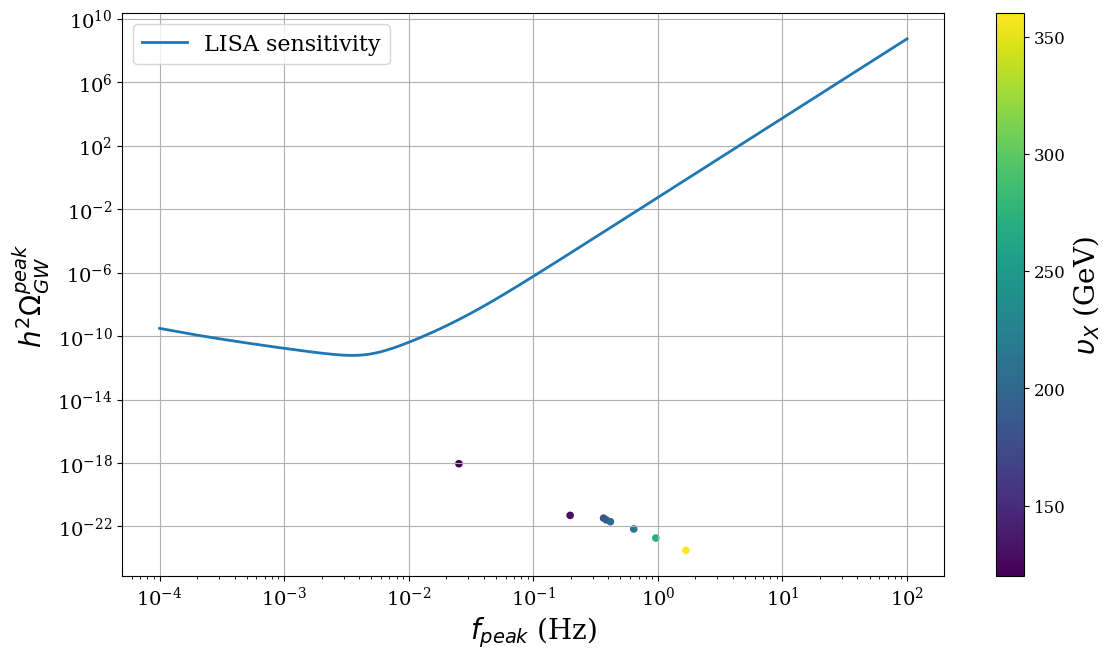

In [ ]:
# Plotting the results with LISA sensitivity curve

H = 3.24e-18 # Hubble constant in Hz

plt.figure(figsize=(12,7))

fpeak = [frequencies[i] for i in range(len(scan_param))]
Ω_peak = [amp_less[i] if Hτ_val[i]<=0.95 else amp_τ[i] for i in range(len(scan_param))]
            
def Sn(f): # Noise spectral density for LISA
    
    c = 3e8
    L = 2.5e9
    
    def Sn_acc(f):
        
        return 9*(1e-30)*(1+(1e-4/f))/((2*pi*f)**4)
    
    Sn_sn = 2.34*(1e-23)
    Sn_omn = 2.65*(1e-23)
    
    Sn = (20/3)*(1/L**2)*(4*Sn_acc(f) + Sn_sn + Sn_omn)*(1 + (f/(0.41*(c/(2*L))))**2)
    
    return Sn

freq = np.linspace(1e-4,1e2,1000000)

def Ω_sens(f): # LISA sensitivity curve
    return ((2*pi**2)/(3*H**2))*Sn(f)*f**3

Ω_sens_val = [Ω_sens(f) for f in freq]

plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif",
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "legend.fontsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "lines.linewidth": 2,
})

scatter = plt.scatter(fpeak, Ω_peak, c = scan_param, cmap = 'viridis', s = 20)
cbar = plt.colorbar(scatter)
cbar.set_label(r'$\upsilon_X$ (GeV)', fontsize=20)
cbar.ax.tick_params(labelsize=12)
plt.plot(freq, Ω_sens_val, label = r'LISA sensitivity')

plt.xlabel(r'$f_{peak}$ (Hz)')
plt.ylabel(r'$h^2Ω^{peak}_{GW}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("new_BP3_vx_scan.pdf", format='pdf', bbox_inches='tight')

In [ ]:
# Plotting vn/Tn against the scanned parameter (θsx in this case)

plt.figure(figsize=(10,6))
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif",
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "legend.fontsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "lines.linewidth": 2,
})
plt.scatter(scan_param, vn_Tn)
plt.xlabel(r'$θ_{SX}$')
plt.ylabel(r'$\upsilon_n$/$T_n$')
plt.grid(True)
plt.savefig("strength_θsx_scan.pdf", format='pdf', bbox_inches='tight')

In [ ]:
# Alternative method for obtaining the couplings

def alt_couplings():
    
    M_diag = np.diag([M12,M22,M32])

    M2 = R.T @ M_diag @ R

    λφ = M2[0, 0] / (2 * vh2)
    λS = M2[1, 1] / (2 * vs2)
    λX = M2[2, 2] / (2 * vx2)

    λφs = M2[0, 1] / (vh * vs)
    λφx = M2[0, 2] / (vh * vx)
    λsx = M2[1, 2] / (vs * vx)
    
    return λφ, λS, λX, λφs, λφx, λsx

# Again, check if the couplings provide a stable potential  
print("\n")
print(λφ,λS,λX)
print("\n")

λφs_bar, λφx_bar, λsx_bar = λφs + 2*sqrt(λφ*λS), λφx + 2*sqrt(λφ*λX), λsx + 2*sqrt(λS*λX)
print(λφs_bar, λφx_bar, λsx_bar)
print("\n")

print(sqrt(λS)*λφx + sqrt(λX)*λφs + sqrt(λφ)*λsx + sqrt(λφ*λS*λX) + sqrt(λφs_bar*λφx_bar*λsx_bar))

In [ ]:
# Plot potential landscapes at different temperatures

from IPython.display import display, HTML

list_a = [(500,0)]
list_h = [(0,246.22),(170,141),(200,0),(800,0)]
list_s = [(300,0)]

def Vplots(param_list,model,save_plots=True, output_dir="Potential_Plots"):
    
    a_vals = np.linspace(-500, 500, 500)
    s_vals = np.linspace(-200, 200, 500)
    A, S = np.meshgrid(a_vals, s_vals)

    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
    
    plt.style.use('default')
    plt.rcParams.update({
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
    
    output = []
    
    for i, (t,h) in enumerate(param_list):
        m = model(M)
        V = np.zeros_like(A)

        for u in range(A.shape[0]):
            for v in range(A.shape[1]):
                a = A[u, v]
                s = S[u, v]
                X = np.array([h, s, a])
                V[u, v] = m.Vtot(X, t)

        v = m.findMinimum()
        
        fig = plt.figure(figsize=(12, 6), frameon=False)
    
        # 2D Contour plot
        ax2d = fig.add_subplot(121)
        c = ax2d.contourf(A, S, V, levels=150, cmap='turbo')
        ax2d.set_xlabel("X (GeV)",fontsize=12,color='black')
        ax2d.set_ylabel("S (GeV)",fontsize=12,color='black')
        fig.colorbar(c, ax=ax2d, shrink=0.8,label = r'V ($GeV^4$)')

        # 3D Surface plot
        ax3d = fig.add_subplot(122, projection='3d', facecolor='none')
        surf = ax3d.plot_surface(A, S, V, cmap='turbo', edgecolor='none')
        ax3d.grid(True, color='gray', linestyle=':', alpha=0.5)
        ax3d.set_xlabel("X (GeV)", fontsize=12, labelpad=10)
        ax3d.set_ylabel("S (GeV)", fontsize=12, labelpad=10)
        fig.colorbar(surf, ax=ax3d, shrink=0.6, label = r'V ($GeV^4$)')

        fig.suptitle(f"T={t} GeV, H = {h} GeV", y=1.02, fontsize=14)
        plt.tight_layout()
        
        if save_plots:
            plot_filename = os.path.join(output_dir, f"plot_{i+1}.pdf")
            fig.savefig(plot_filename, facecolor="white", dpi=150, bbox_inches='tight')
            
        output.append(HTML(f"<hr style='margin: 30px 0;'>")) 
        output.append(fig)
        plt.close(fig)


    display(*output)

Vplots(param_list=list_h, model=TRSM)